#  PyTorch Lightning. Разворачивание веб-сервера для использования моделей.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://lightning.ai/docs/pytorch/stable/starter/introduction.html
* https://lightning.ai/docs/pytorch/stable/levels/core_skills.html
* https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html#lightning.pytorch.core.LightningModule.log
* https://lightning.ai/docs/pytorch/stable/extensions/logging.html
* https://lightning.ai/docs/pytorch/stable/common/progress_bar.html
* https://lightning.ai/docs/pytorch/stable/common/early_stopping.html
* https://lightning.ai/docs/pytorch/1.6.3/api/pytorch_lightning.utilities.model_summary.html#pytorch_lightning.utilities.model_summary.ModelSummary
* https://torchmetrics.readthedocs.io/en/stable/pages/lightning.html
* https://pykit.org/how-to-run-python-flask-app-online-using-ngrok/

## Задачи для совместного разбора

1\. Создайте датасет для регрессии и обучите модель при помощи PyTorch Lightning.

## Задачи для самостоятельного решения

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 20.0 MB/s eta 0:00:00


In [2]:
import torch.nn as nn
import torch.optim as optim
import lightning as L
import torch.nn.functional as F
from torchmetrics import Accuracy
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from bs4 import BeautifulSoup
from torch.utils.data import Dataset
from torchvision.transforms import  v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pytorch_lightning as pl

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cuda'

<p class="task" id="1"></p>

1\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.  Разбейте набор данных на обучающее и валидационное множество. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

- [ ] Проверено на семинаре

In [3]:
def parse_xml(path):
  with open(path, 'r') as f:
    data = f.read()
  Bs_data = BeautifulSoup(data, "xml")

  obj_name = Bs_data.find('name').text
  w = int(Bs_data.find('width').text)
  h = int(Bs_data.find('height').text)

  coor_names = ['xmin', 'ymin', 'xmax', 'ymax']
  raw_coor = {name: float(Bs_data.find(name).text) for name in coor_names}

  scaled_coor = {
      'xmin': raw_coor['xmin']/w,
      'ymin': raw_coor['ymin']/h,
      'xmax': raw_coor['xmax']/w,
      'ymax': raw_coor['ymax']/h
      }

  d = {
      "raw": raw_coor,
      "scaled": scaled_coor,
      "obj_name": obj_name
      }

  return d

In [4]:
from torch.utils.data import Dataset

get_file_name = np.vectorize(lambda root, x: '/'.join([root, x[:-4]]))

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        files = os.listdir(self.root)
        self.file_names = np.unique(get_file_name(root, files))

    def __getitem__(self, index):
        name = self.file_names[index]
        annot = parse_xml('.'.join([name, 'xml']))
        img = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(Image.open('.'.join([name, 'jpg'])))

        if self.transforms:
          img = self.transforms(img)

        if self.return_scaled:
          bbox = annot['scaled']
        else:
          bbox = annot['raw']

        if self.target_transform:
          label = self.target_transform.transform([annot['obj_name']])
        else:
          label = annot['obj_name']

        return img, bbox, label

    def __len__(self):
        return len(self.file_names)

In [5]:
le = LabelEncoder().fit(['cat', 'dog'])
root = "/content/drive/MyDrive/Учеба/DL/06_cv/Asirra: cat vs dogs"
dataset = AnimalDetectionDataset(root, transforms=ResNet50_Weights.IMAGENET1K_V2.transforms(), target_transform=le)

batch_size = 32
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<p class="task" id="2"></p>

2\. Напишите модель для решения задачи выделения объектов в виде объекта `lightning.LightningModule`. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`. В качестве функции потерь используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации).

Реализуйте следующий функционал при помощи `lightning` и `torchmetrics`:
* для каждого батча во время обучения рассчитывается значение функции потерь и точности прогнозов, по завершению эпохи метрики усредняются;
* для каждого батча во время валидации рассчитывается значение функции потерь и точности прогнозов, по завершению эпохи метрики усредняются;
* если значение функции потерь не улучшалось в течении 5 эпох, происходит ранняя остановка;
* при создании модель на экран выводится сводка по модели с указанием размерностей выходов слоев;
* для визуализации процесса обучения используется tensorboard.

Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [7]:
class Detector(L.LightningModule):
  def __init__(self, num_classes=2):
    super().__init__()
    self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
    for param in self.backbone.parameters():
        param.requires_grad = False

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, num_classes)
    )

    self.regressor = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 4)
    )
    self.learning_rate = 0.001
    self.loss_fn_classification = nn.CrossEntropyLoss()
    self.loss_fn_regression = nn.MSELoss()
    self.accuracy = Accuracy(task='binary')

    self._log_model_summary()

  def forward(self, input):
    out = self.backbone(input)
    cl_out = self.classifier(out)
    reg_out = self.regressor(out)
    return cl_out, reg_out

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    images, labels_bbox, labels_cls = batch
    labels_bbox = torch.stack(list(labels_bbox.values())).T.float()
    logits_cls, bbox_preds = self(images)
    loss_cls = self.loss_fn_classification(logits_cls, labels_cls.flatten().long())
    loss_bbox = self.loss_fn_regression(bbox_preds, labels_bbox)
    total_loss = loss_cls + loss_bbox

    self.log('train_loss', total_loss)
    return total_loss

  def validation_step(self, batch, batch_idx):
    images, labels_bbox, labels_cls = batch
    labels_bbox = torch.stack(list(labels_bbox.values())).T.float()
    logits_cls, bbox_preds = self(images)

    loss_cls = self.loss_fn_classification(logits_cls, labels_cls.flatten().long())
    loss_bbox = self.loss_fn_regression(bbox_preds, labels_bbox)
    total_loss = loss_cls + loss_bbox
    self.log('val_loss', total_loss)
    accuracy = self.accuracy(logits_cls.argmax(axis=1), labels_cls.flatten().long())
    self.log('val_accuracy', accuracy, prog_bar=True)

    return total_loss

  def _log_model_summary(self):
    sample_input = torch.randn(1, 3, 224, 224)
    backbone_out = self.backbone(sample_input)
    classification_out = self.classifier(backbone_out)
    regression_out = self.regressor(backbone_out)
    print(f"{backbone_out.shape = }")
    print(f"{classification_out.shape = }")
    print(f"{regression_out.shape = }")

In [8]:
model = Detector(num_classes=2).to(device)

trainer = L.Trainer(
    max_epochs=50,
    callbacks=[L.pytorch.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=5)],
    logger=L.pytorch.loggers.TensorBoardLogger('logs/', name='object_detection_model')
)
trainer.fit(model, train_loader, test_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


backbone_out.shape = torch.Size([1, 2048, 1, 1])
classification_out.shape = torch.Size([1, 2])
regression_out.shape = torch.Size([1, 4])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                   | Type             | Params
------------------------------------------------------------
0 | backbone               | Sequential       | 23.5 M
1 | classifier             | Sequential       | 4.1 K 
2 | regressor              | Sequential       | 8.2 K 
3 | loss_fn_classification | CrossEntropyLoss | 0     
4 | loss_fn_regression     | MSELoss          | 0     
5 | accuracy               | BinaryAccuracy   | 0     
------------------------------------------------------------
12.3 K    Trainable params
23.5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

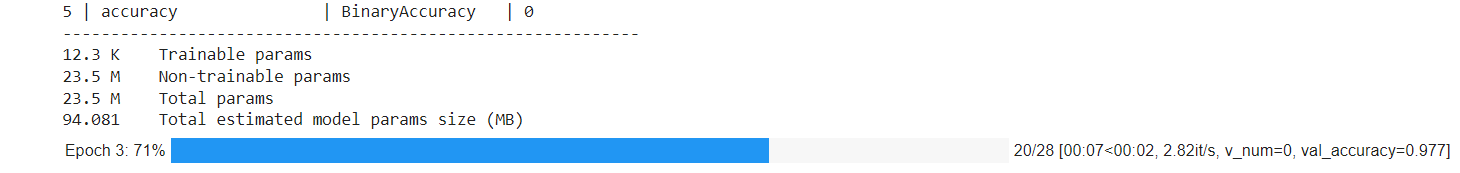

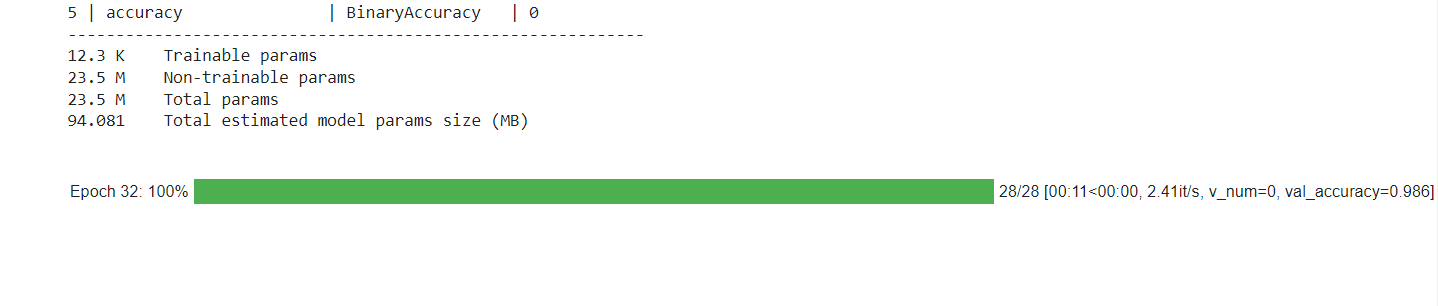

In [10]:
def show_image_with_bounding_box(dset_instance, pred=None, target_transform=None, scaled=False, mean=None, std=None): # pred=(box_pred, label_pred)
  img = dset_instance[0]
  if mean is not None and std is not None:
    img = img*std.reshape(-1,1,1) + mean.reshape(-1,1,1)

  xmin, ymin, xmax, ymax = dset_instance[1].values()
  if scaled:
    xmin, ymin, xmax, ymax = xmin*img.shape[-1], ymin*img.shape[-2], xmax*img.shape[-1], ymax*img.shape[-2]

  label = dset_instance[2]
  if not isinstance(label, str):
    label = target_transform.inverse_transform(label)[0]

  width = xmax - xmin
  height = ymax - ymin
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='tab:green', facecolor='none', label='True')

  fig, ax = plt.subplots(1)
  ax.imshow(img.permute(1,2,0))
  ax.add_patch(rect)
  plt.text((xmax+xmin)/2-10, ymin-10, label, color='tab:green', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

  if pred:
    label = target_transform.inverse_transform([pred[1]])[0]
    xmin, ymin, xmax, ymax = pred[0]
    if scaled:
      xmin, ymin, xmax, ymax = pred[0]*torch.tensor([img.shape[-1], img.shape[-2], img.shape[-1], img.shape[-2]])
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
    ax.add_patch(rect)
    plt.text((xmax+xmin)/2-10, ymin-10, label, color='r', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))
  plt.legend()
  plt.show()

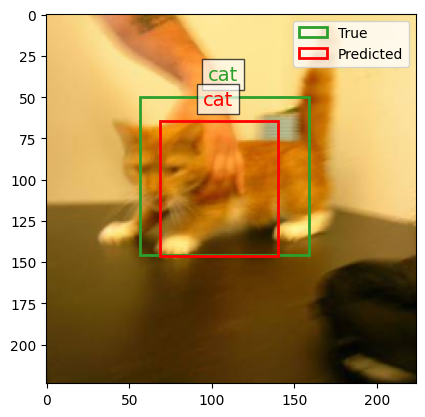

In [12]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# cat
model.eval()
cl_out, reg_out = model(dataset[0][0].unsqueeze(0))

show_image_with_bounding_box(dataset[0], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

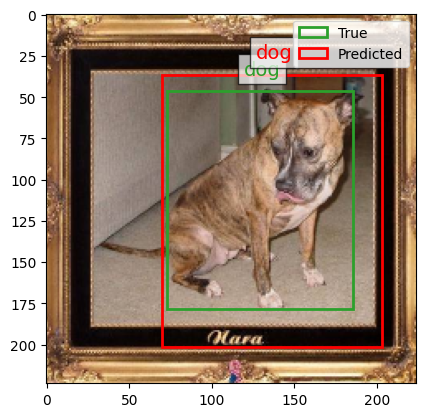

In [13]:
# dog
model.eval()
cl_out, reg_out = model(dataset[-2][0].unsqueeze(0))

show_image_with_bounding_box(dataset[-2], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

<p class="task" id="3"></p>

3\. Загрузите чекпоинт обученной модели и переведите модель в режим оценки. Допишите функцию `transform_image` и route `predict`. Запустите сервер flask и сделайте POST-запрос к соответствующему эндпоинту.

При работе в Google Colab вы можете воспользоваться инструментом `ngrok` для проброса локального адреса или запустить сервер Flask в отдельном потоке.

- [ ] Проверено на семинаре

In [ ]:
from PIL import Image
import io
from torchvision.transforms import v2 as T
import torch

def bytes_to_pil(image_bytes: bytes) -> Image:
    return Image.open(io.BytesIO(image_bytes))

def transform_image(image: Image) -> torch.Tensor:
    """Преобразует PIL.Image в тензор"""
    pass

In [ ]:
from flask import Flask
# from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
import threading


ALLOWED_EXTENSIONS = {"png", "jpg", "jpeg"}


def allowed_file(filename):
    return "." in filename and filename.rsplit(".", 1)[1].lower() in ALLOWED_EXTENSIONS


app = Flask(__name__)  # app name
# run_with_ngrok(app)


@app.route("/predict", methods=["POST"])
def predict():
    if request.method == "POST":
        file = request.files.get("file")
        if file is None or file.filename == "":
            return jsonify({"error": "no file"})
        if not allowed_file(file.filename):
            return jsonify({"error": "format not supported"})
        try:
            img_bytes = file.read()
            image = bytes_to_pil(img_bytes)
            tensor = transform_image(image)

            # получите прогноз при помощи модели
            data = {
                "bbox": ...,
                "label": ...,
            }
            return jsonify(data)
        except Exception as e:
            return jsonify({"error": f"error during prediction: {e}"})


if __name__ == "__main__":
    threading.Thread(target=lambda: app.run()).start()
    # app.run()

In [ ]:
import requests

resp = requests.post(
    ".../predict",
    files={
        "file": open(
            "path/to/file", "rb"
        )
    },
)

print(resp.text)

## Обратная связь
- [ ] Хочу получить обратную связь по решению